# Abstract

Title: A Computer Vision System for Generalizable Information Extraction

The goal of this paper is to build a system that can "understand" any video or visual interface by extracting the information contained within it and modeling and analyzing it based on assumptions about the relationships between different entities. Such a system would enable applications such as data mining interfaces with no native APIs, desktop environment routine programming, ..., and would be a step toward a system that can interpret, "understand", and interact with real environments.

# Introduction

## Motivation


There are many visual interfaces for which there are no native APIs. This makes extracting information from and interacting with many visual mediums difficult, if not impossible. By learning how to recognize different visual entities (e.g., text, objects, people, etc.) and considering known relationships about those entities, an agent can extract information from, make infrences about, and interact with a wide variety of scenes based on their contents.

## Previous Work

### Computer Vision Systems for Information Extraction

In 2013, Guarino de Vasconcelos et al. built a computer vision system to extract information from the Heads-Up Display (HUD) of flight test simulators used by the Instituto Tecnológico de Aeronáutica in Brazil [[1](https://www.researchgate.net/publication/288157083_Using_image_processing_and_pattern_recognition_in_images_from_head-up_display)]. 
Text information was extracted by extracting preset patches of video frames and matching against a database of known characters by computing correlation coefficients (r).

In 2005, for his undergraduate thesis at Brown, Haruyoshi Sakai designed a computer vision system to collect data from online poker clients [[2](https://cs.brown.edu/research/pubs/theses/ugrad/2005/hsakai.pdf)]. Since the poker client's user interface always uses the same font and graphics in static locations, Sakai chose to collect information via trie-based template matching, which uses tries to matches against a known database of text and game elements (e.g., usernames, bet sizes, cards' values and suits), at fixed locations. Sakai also built a model of the poker game, with game logic, in which to store the extracted information, which he used to infer statistics about the winningest and losingest players, the hand that resulted in the largest pot, and the number of occurrences of various hands. 

More recently, SeeBiBytes, a research project headed by the Department of Engineering Science at the University of Oxford, has built several computer vision systems that are able to interpret complex visual input and provide queryable data based on its contents [[3](http://www.robots.ox.ac.uk/~vgg/projects/seebibyte/demo.html)]. In particular, they have built: a database of news broadcasts which can be queried for text, objects, landmarks, and people; a database of paintings which can be queried for certain objects (apple, boat, dog, etc.); and systems that can detect and localize different entities such in an image such as text and human body parts.

## Bag-of-Visual-Words Model

https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision#Feature_representation
https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision#Codebook_generation

# Algorithms

## Object Detection

### Feature Descriptors

The goal of feature detection in computer vision is to detect the keypoints within an image that best distinguish it from other images. These keypoints often consist of edges and corners because of their distinctness; intuitively, an edge or a corner is more useful in identify an object's shape or form than a flat region without much variability. In practice, this variability is analyzed by taking the gradient at different points in an image (or some abstract representation of the image, e.g., its [scale space](https://en.wikipedia.org/wiki/Scale_space)) and selecting local extrema. Then, a high-dimensional descriptor is created for each keypoint by considering the region around the keypoint, such that descriptors corresponding to similar keypoints will be nearby in the descriptor space.

![sift](sift.png)

### Bag-of-Visual-Words Model

Once we have keypoints and feature descriptors, we can cluster the descriptor space to form "visual words", leading us to the Bag-of-Visual-Words (BOVW) model, an analog of the Bag-of-Words model from Natural Language Processing. A histogram of the visual words present in an image is then created and used for modeling. This histogram space is much easier to model compared to the original image space because of its much smaller size and complexity.

![bovw](bovw.png)
![bovw histogram](bovw_histogram.png)

### Spatial Pyramidal Features

There are many ways to model an image through BOVW histograms. One such way is a Spatial Pyramidal Features (SPF) model. An SPF model considers an image as a pyramid of histograms, with each subsequent level in the pyramid considering histograms of progressively smaller subimages. This space of pyramids of histograms allows for more precise modeling compared to the space of single histograms at the cost of higher complexity.

![SPF](spatial_pyramidal_features.png)

## Object Localization

### Efficient Subwindow Search

While there are many algorithms designed to detect the presence of objects in an image, considerably less time has been put into algorithms designed to localize objects within an image. There are many techniques for object localization, ranging from naive ([sliding window search](https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/)) to complex ([Recurrent Convolutional Neural Networks (RCNNs)](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/object_localization_and_detection.html)). In order to optimize the results of a sliding window search, an image must be searched with many window sizes and small strides, and even then, only a small fraction of the entire search space can be covered. And neural networks generally require a large training set of unique examples to produce a robust network. A promising alternative to these algorithms is [Efficient Subwindow Search (ESS)](http://www.kyb.mpg.de/publications/pdfs/pdf5070.pdf), which operates over a BOVW model. ESS is a branch-and-bound algorithm; this means that it uses the estimated bounds of a quality function to recursively split and narrow down the search space in order to find a global optimum for the quality function. The quality function for ESS pertains to presence of visual words matching some template image's BOVW histogram; essentially, the algorithm hones in on regions within an image that have histograms more similar to the histogram of the template image, elminating the need to spend time searching irrelevant regions. Lampert et al showed that in many cases, this produces a higher quality match with less quality function evaluations than a sliding window search.

![ESS](ess.png)

# Code

## Imports

### Libraries

In [1]:
import cv2; print('cv2=%s' % cv2.__version__)
import numpy as np; print('numpy=%s' % np.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sklearn; print('sklearn=%s' % sklearn.__version__)

cv2=3.4.2
numpy=1.15.2
sklearn=0.20.1


### Test Images

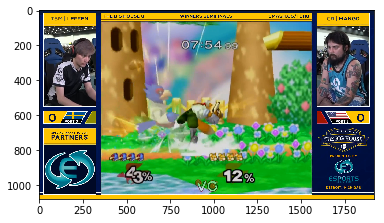

In [4]:
img1_path = '../data/smash/fox/bair_right.png'
img1 = cv2.imread(img1_path, 0)
img1_col = cv2.imread(img1_path)[:,:,::-1]

img2_path = '../data/smash/test.png'
img2 = cv2.imread(img2_path, 0)
img2_col = cv2.imread(img2_path)[:,:,::-1]

plt.imshow(img2_col); plt.show()

## Algorithms

### Feature Detection

#### SIFT

In [26]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures=5000, contrastThreshold=0.01, edgeThreshold=20, sigma=1.6)
# https://docs.opencv.org/3.4.2/d5/d3c/classcv_1_1xfeatures2d_1_1SIFT.html

kp1_sift, des1_sift = sift.detectAndCompute(img1, None)
kp2_sift, des2_sift = sift.detectAndCompute(img2, None)

print(len(kp1_sift))
print(img1.shape[:2])
print(kp1_sift[-1].pt)
print(des1_sift[0])
print(len(des1_sift[0]))
print(len(des2_sift))
print(len(kp2_sift))

error: OpenCV(3.4.2) /io/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1121: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'detectAndCompute'


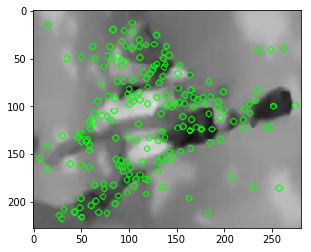

(228, 281)
(7.055309295654297, 154.805419921875)
(14.773707389831543, 141.20362854003906)
(14.808058738708496, 165.60867309570312)
(15.634870529174805, 15.142683982849121)
(26.816322326660156, 214.20025634765625)
(29.54660987854004, 218.08868408203125)
(30.112668991088867, 131.0795135498047)
(32.191463470458984, 207.84524536132812)
(35.213619232177734, 50.24553298950195)
(38.88605499267578, 160.41636657714844)
(43.08055877685547, 210.76158142089844)
(43.352542877197266, 210.4122314453125)
(46.55521011352539, 133.0645294189453)
(48.03986358642578, 128.5926055908203)
(48.310855865478516, 206.21876525878906)
(49.22102737426758, 161.645751953125)
(49.52955627441406, 196.85086059570312)
(49.94416809082031, 136.8858642578125)
(50.27652359008789, 48.258079528808594)
(50.343170166015625, 216.2129364013672)
(50.343170166015625, 216.2129364013672)
(51.21758270263672, 129.6613311767578)
(55.384342193603516, 137.07931518554688)
(55.384342193603516, 137.07931518554688)
(56.8365364074707, 135.198867

In [243]:
plt.imshow(cv2.drawKeypoints(img1, kp1_sift, None, color=(0,255,0), flags=0)); plt.show()
print(img1.shape[:2])
for kp in kp1_sift:
    print(kp.pt)

(984, 1204)


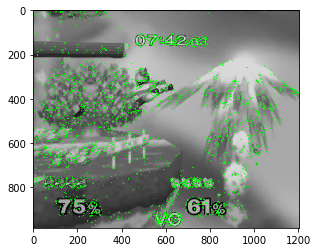

In [233]:
print(img2.shape)
plt.imshow(cv2.drawKeypoints(img2, kp2_sift, None, color=(0,255,0), flags=0)); plt.show()

In [6]:
img_flann_sift, is_match = flann(1, (img1, kp1_sift, des1_sift), (img2, kp2_sift, des2_sift))
if is_match:
    plt.imshow(img_flann_sift); plt.show()

NameError: name 'flann' is not defined

#### SURF

In [234]:
surf = cv2.xfeatures2d.SURF_create()
# https://docs.opencv.org/3.4.2/d5/df7/classcv_1_1xfeatures2d_1_1SURF.html

kp1_surf, des1_surf = surf.detectAndCompute(img1, None)
kp2_surf, des2_surf = surf.detectAndCompute(img2, None)

print(len(kp1_surf))
print(len(kp2_surf))

158
3195


In [ ]:
plt.imshow(cv2.drawKeypoints(img1, kp1_surf, None, color=(0,255,0), flags=0)); plt.show()

In [ ]:
plt.imshow(cv2.drawKeypoints(img2, kp2_surf, None, color=(0,255,0), flags=0)); plt.show()

In [ ]:
img_flann_surf, is_match = flann(1, (img1, kp1_surf, des1_surf), (img2, kp2_surf, des2_surf))
if is_match:
    plt.imshow(img_flann_surf); plt.show()

#### ORB

In [93]:
orb = cv2.ORB_create(5000, edgeThreshold=10, patchSize=10, scaleFactor=1.2, nlevels=8)
# https://docs.opencv.org/3.4.2/db/d95/classcv_1_1ORB.html

kp1_orb, des1_orb = orb.detectAndCompute(img1, None)
kp2_orb, des2_orb = orb.detectAndCompute(img2, None)

print(len(kp1_orb))
print(len(kp2_orb))

441
5000


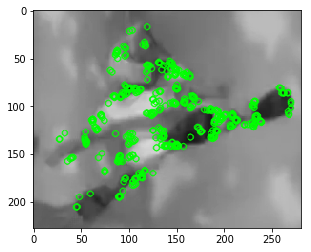

(228, 281)
(117.0, 37.0)
(146.0, 58.0)
(124.0, 61.0)
(145.0, 61.0)
(161.0, 65.0)
(141.0, 69.0)
(160.0, 69.0)
(164.0, 69.0)
(108.0, 82.0)
(101.0, 83.0)
(112.0, 83.0)
(107.0, 84.0)
(110.0, 85.0)
(262.0, 86.0)
(267.0, 86.0)
(95.0, 87.0)
(98.0, 87.0)
(85.0, 91.0)
(91.0, 91.0)
(169.0, 93.0)
(173.0, 95.0)
(270.0, 95.0)
(149.0, 97.0)
(270.0, 97.0)
(270.0, 102.0)
(187.0, 103.0)
(187.0, 105.0)
(267.0, 106.0)
(202.0, 109.0)
(268.0, 109.0)
(124.0, 110.0)
(62.0, 114.0)
(213.0, 115.0)
(190.0, 118.0)
(206.0, 122.0)
(231.0, 122.0)
(66.0, 125.0)
(137.0, 126.0)
(193.0, 126.0)
(133.0, 134.0)
(188.0, 134.0)
(54.0, 136.0)
(146.0, 138.0)
(55.0, 140.0)
(140.0, 141.0)
(144.0, 142.0)
(148.0, 142.0)
(157.0, 142.0)
(91.0, 152.0)
(88.0, 158.0)
(93.0, 158.0)
(114.0, 175.0)
(107.0, 177.0)
(48.0, 195.0)
(91.0, 195.0)
(117.60000610351562, 37.20000076293945)
(87.60000610351562, 42.0)
(142.8000030517578, 52.80000305175781)
(144.0, 61.20000076293945)
(148.8000030517578, 61.20000076293945)
(160.8000030517578, 64.8000030

In [95]:
plt.imshow(cv2.drawKeypoints(img1, kp1_orb, None, color=(0,255,0), flags=0)); plt.show()
print(img1.shape[:2])
for kp in kp1_orb:
    print(kp.pt)

In [ ]:
plt.figure(figsize=(30,30))
plt.imshow(cv2.drawKeypoints(img2, kp2_orb, None, color=(0,255,0), flags=0)); plt.show()

In [ ]:
img_flann_orb, is_match = flann(6, (img1, kp1_orb, des1_orb), (img2, kp2_orb, des2_orb))
if is_match:
    plt.imshow(img_flann_orb); plt.show()

In [ ]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1_orb, des2_orb)

# Sort them in the order of their distance.
matches = sorted(matches, key=lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1_orb,img2,kp2_orb,matches[:4], None, flags=2)

plt.imshow(img3); plt.show()

#### FLANN

In [ ]:
def flann(algorithm, img_kp_des1, img_kp_des2, good_ratio=0.8, min_match_count=10, quiet=False):
    img1, kp1, des1 = img_kp_des1
    img2, kp2, des2 = img_kp_des2
    
    index_params = dict(algorithm=algorithm)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    # https://docs.opencv.org/3.4.2/dc/de2/classcv_1_1FlannBasedMatcher.html
    
    matches = flann.knnMatch(des1, des2, 2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < good_ratio*n.distance:
            good.append(m)

    img_match = img2.copy()
    if len(good) >= min_match_count:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts, M)

        cv2.polylines(img_match, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    else:
        if not quiet:
            print("Not enough matches are found - {}/{}".format(len(good), min_match_count))
        matchesMask = None

    draw_params = dict(matchColor=(0,255,0), # draw matches in green color
                       singlePointColor=None,
                       matchesMask=matchesMask, # draw only inliers
                       flags=2)

    img_match = cv2.drawMatches(img1, kp1, img_match, kp2, good, None, **draw_params)
    return img_match, (matchesMask is not None)

#### MSER

In [ ]:
mser = cv2.MSER_create(_delta=4, _max_variation=0.3)
# https://docs.opencv.org/3.4.2/d3/d28/classcv_1_1MSER.html

mser1, bboxes1 = mser.detectRegions(img1)
mser2, bboxes2 = mser.detectRegions(img2)

In [ ]:
hulls1 = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in mser1]
img1_mser = img1.copy()
cv2.polylines(img1_mser, hulls1, 1, 0)
plt.imshow(img1_mser, cmap='gray'); plt.show()

In [ ]:
mser_vis1 = img1.copy()
for bbox in bboxes1:
    pt1 = (bbox[0], bbox[1])
    pt2 = (bbox[0]+bbox[2], bbox[1]+bbox[3])
    cv2.rectangle(mser_vis1, pt1, pt2, 0)
plt.imshow(mser_vis1, cmap='gray'); plt.show()

In [ ]:
hulls2 = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in mser2]
img2_mser = img2.copy()
cv2.polylines(img2_mser, hulls2, 1, 0)
plt.figure(figsize=(30,30))
plt.imshow(img2_mser, cmap='gray'); plt.show()

In [ ]:
mser_vis2 = img2.copy()
for bbox in bboxes2:
    pt1 = (bbox[0], bbox[1])
    pt2 = (bbox[0]+bbox[2], bbox[1]+bbox[3])
    cv2.rectangle(mser_vis2, pt1, pt2, 0)
plt.figure(figsize=(30,30))
plt.imshow(mser_vis2, cmap='gray'); plt.show()

#### MSER Region Extraction

In [16]:
PATCH_SIZE = (40, 40)
orb = cv2.ORB_create(5000, edgeThreshold=5)
sift = cv2.xfeatures2d.SIFT_create(nfeatures=5000, contrastThreshold=0.01, edgeThreshold=20, sigma=1.6)
surf = cv2.xfeatures2d.SURF_create()

In [17]:
patches1 = []
keypoint_sets1, descriptor_sets1 = [], []
extractor = orb
# https://docs.opencv.org/3.4.2/db/d95/classcv_1_1ORB.html

black1 = np.zeros_like(img1)
for hull, bbox in zip(hulls1, bboxes1):
    pt1 = (bbox[0], bbox[1]) # top left
    pt2 = (bbox[0]+bbox[2], bbox[1]+bbox[3]) # bottom right
    
    # create mask
    mask = black1.copy()
    cv2.drawContours(mask, [hull], -1, 255, -1)
    mask_normed = cv2.resize(mask[pt1[1]:pt2[1], pt1[0]:pt2[0]], PATCH_SIZE)
    r, mask_normed = cv2.threshold(mask_normed, 127, 255, cv2.THRESH_BINARY)
    
    # extract patch
    patch = img1[pt1[1]:pt2[1], pt1[0]:pt2[0]]
    patch_normed = cv2.resize(patch, PATCH_SIZE)
    
    # find keypoints+descriptors
    keypoints, descriptors = extractor.detectAndCompute(patch_normed, mask_normed)
    keypoint_sets1.append(keypoints)
    descriptor_sets1.append(descriptors)
    
    # mask patch
    patch_normed_masked = cv2.bitwise_and(patch_normed, patch_normed, mask=mask_normed)
    
    patches1.append(patch_normed_masked)

NameError: name 'hulls1' is not defined

In [15]:
patches2 = []
keypoint_sets2, descriptor_sets2 = [], []
extractor = orb

black2 = np.zeros_like(img2)
for hull, bbox in zip(hulls2, bboxes2):
    pt1 = (bbox[0], bbox[1]) # top left
    pt2 = (bbox[0]+bbox[2], bbox[1]+bbox[3]) # bottom right
    
    # create mask
    mask = black2.copy()
    cv2.drawContours(mask, [hull], -1, 255, -1)
    mask_normed = cv2.resize(mask[pt1[1]:pt2[1], pt1[0]:pt2[0]], PATCH_SIZE)
    r, mask_normed = cv2.threshold(mask_normed, 127, 255, cv2.THRESH_BINARY)
    
    # extract patch
    patch = img2[pt1[1]:pt2[1], pt1[0]:pt2[0]]
    patch_normed = cv2.resize(patch, PATCH_SIZE)
    
    # find keypoints+descriptors
    keypoints, descriptors = extractor.detectAndCompute(patch_normed, mask_normed)
    keypoint_sets2.append(keypoints)
    descriptor_sets2.append(descriptors)
    
    # mask patch
    patch_normed_masked = cv2.bitwise_and(patch_normed, patch_normed, mask=mask_normed)
    
    patches2.append(patch_normed_masked)

NameError: name 'orb' is not defined

In [ ]:
def show_patches(patches, keypoint_sets, dim=(8, 8), cols=8, rows=8, figsize=(8,8), cmap='gray'):
    fig = plt.figure(figsize=figsize)
    for i in range(1, cols*rows+1):
        try:
            patch, kp_orb = patches[i-1], keypoint_sets[i-1]
            fig.add_subplot(rows, cols, i)
            patch_w_kp = cv2.drawKeypoints(patch, kp_orb, None, color=(0,255,0), flags=0)
            plt.imshow(patch_w_kp, cmap='gray')
        except IndexError:
            break
    plt.show()

In [ ]:
show_patches(patches1, keypoint_sets1)

In [ ]:
show_patches(patches2, keypoint_sets2)

### Image Classification

In [9]:
from sklearn.cluster import KMeans
from collections import defaultdict

#### K-Means Clustering (creation of BOVW)

In [ ]:
def create_data_structures(patches, descriptor_sets, labels):
    
    descriptor_to_label = {}
    label_to_patches = defaultdict(list)
    label_to_descriptors = defaultdict(list)
    
    for label, patch, descriptor_set in zip(kmeans.labels_, patches1, descriptor_sets):
        if descriptor_set is not None:
            for descriptor in descriptor_set:
                descriptor_to_label[tuple(descriptor)] = label
                label_to_patches[label].append(patch)
                label_to_descriptors[label].append(descriptor)
    return  descriptor_to_label, label_to_patches, label_to_descriptors

In [10]:
# adapted from https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb

orb = cv2.ORB_create(5000, edgeThreshold=10, patchSize=10, scaleFactor=1.2, nlevels=8)
kp, des = orb.detectAndCompute(img2, None)

# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(n_clusters=75)
kmeans.fit(des)
print(kmeans.inertia_)

#descriptor_to_label, label_to_patches, label_to_descriptors = create_data_structures(patches1, descriptor_sets1, kmeans.labels_)

250213518.05487162


##### Finding optimal K

In [ ]:
descriptor_sets = descriptor_sets2
all_descriptors = [descriptor for descriptor_set in descriptor_sets if descriptor_set is not None for descriptor in descriptor_set]

Ks = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
res = []
for k in Ks:
    print(k)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(all_descriptors)
    res.append(kmeans.inertia_)

In [ ]:
plt.plot(Ks, res, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### SVM (model over BOVW)

In [ ]:
def build_histograms(descriptor_sets, model):
    histograms = np.zeros((len(descriptor_sets), model.n_clusters_))
    for i, descriptors in enumerate(descriptor_sets):
        histograms[i] = build_histogram(descriptors, model)
    return histograms

def build_histogram(descriptors, model):
        histogram = np.zeros(model.n_clusters_)
        for descriptor in descriptors:
            label = model.predict(descriptor)
            histogram[label] += 1
    return histogram

In [ ]:
from sklearn.svm import SVC

bovw_model = kmeans

histograms1 = build_histograms(descriptors1, bovw_model)

svm = SVC(kernel='rbf', C=0.1)  
svm.fit(histograms1, labels1)

### Putting it all together

#### BOVW

In [11]:

def get_keypoints_and_descriptors(im, descriptor_extractor):
    return descriptor_extractor.detectAndCompute(im, None)

def aggregate_descriptors(descriptors_):
    return [descriptor for descriptors in descriptors_ for descriptor in descriptors]

def build_bovw(ims, descriptor_extractor):
    
    kp_and_d = [get_keypoints_and_descriptors(im, orb) for im in ims]
    keypoints, descriptors = zip(*kp_and_d)

    all_descriptors = aggregate_descriptors(descriptors)
    n_unique_descriptors = len(set([tuple(descriptor) for descriptor in all_descriptors]))
    print('# unique descriptors: %d' % n_unique_descriptors)

    kmeans, k = optimize_clusters(all_descriptors, cluster_sizes=[1,2,4,8,16,32])
    print('optimal k: %d' % k)
    
    return kmeans

def build_bovw_histogram(cluster_model, kp_and_d):
    histogram = np.zeros(cluster_model.n_clusters)
    
    _, descriptors = kp_and_d
    for c_i in cluster_model.predict(descriptors):
        histogram[c_i] += 1
    return histogram


In [13]:
from math import sqrt, log

def get_knee_point(data):
    # adapted from https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
    
    n_points = data.shape[0]
    first_point = data[0,:]
    last_point = data[-1,:]
    line_vec = last_point - first_point
    line_vec_normed = line_vec / sqrt(line_vec.dot(line_vec))
    vec_from_first = [point - first_point for point in data]
    line_vec_normed_many = np.repeat(np.array([line_vec_normed]), n_points, axis=0)
    scalar_product = (vec_from_first * line_vec_normed_many).sum(axis=1)
    vec_from_first_parallel = line_vec_normed_many* scalar_product[:,np.newaxis]
    vec_to_line = vec_from_first - vec_from_first_parallel
    
    vfunc_sqrt = np.vectorize(sqrt)
    dist_to_line = vfunc_sqrt((vec_to_line * vec_to_line).sum(axis=1))
    
    plt.figure()
    plt.plot(data[:,0], data[:,1], 'bx-')
    plt.xlabel('k')
    plt.ylabel('sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    
    plt.figure()
    plt.plot(data[:,0], dist_to_line, 'bx-')
    plt.xlabel('k')
    plt.ylabel('distance to line')
    plt.title('Knee Point For Optimal k')
    plt.show()
    
    index_of_max = max(enumerate(dist_to_line), key=lambda i_dist: i_dist[1])[0]
    point = data[index_of_max, 0]
    return point
    

def optimize_clusters(data_to_cluster, cluster_sizes=[1,2,4,8,16,32,64,128,256,512,1024]):
    models = {}
    scores = []
    for k in cluster_sizes:
        print('k: %s' % k, end=' ')
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data_to_cluster)
        score = log(kmeans.inertia_)
        print(', score: %f' % score)
        models[k] = kmeans
        scores.append(score)
    cluster_score_data = np.stack((np.array(cluster_sizes), scores), axis=-1)
    k = get_knee_point(cluster_score_data)

    return models[k], k


# unique descriptors: 5436
k: 1 , score: 20.285799
k: 2 , score: 20.149103
k: 4 , score: 19.979129
k: 8 , score: 19.840575
k: 16 , score: 19.697643
k: 32 , score: 19.570911


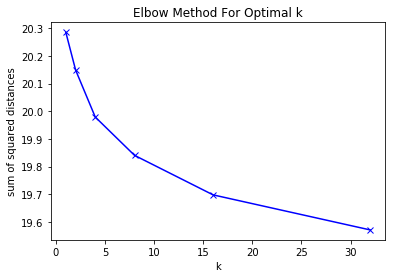

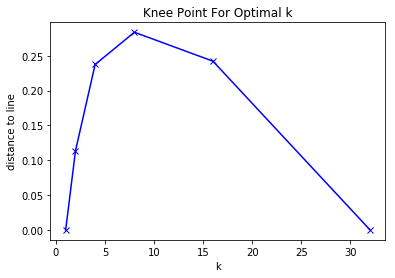

optimal k: 8
[133.  88.  11.  73.  12.  38.  11.  75.]


In [14]:
ims = [img1_col, img2]
orb = cv2.ORB_create(5000, edgeThreshold=10, patchSize=10, scaleFactor=1.2, nlevels=8)
bovw = build_bovw(ims, orb)

im = img1_col
kp_and_d = get_keypoints_and_descriptors(im, orb)
print(build_bovw_histogram(bovw, kp_and_d))

#### Colors

In [15]:
def reduce_image(im, n_bins=3):
    
    reduce_ = lambda x: int((x+1)/(256/n_bins))
    vfunc = np.vectorize(reduce_)
    reduced_im = vfunc(im)
    
    return reduced_im
    
    
def build_colors_histogram(im, n_bins=3):
    
    reduced_im = reduce_image(im, n_bins=n_bins)
    h, w = im.shape[:2]
    n_channels = len(im[0][0]) if type(im[0][0]) == np.ndarray else 1
    
    histogram = np.zeros([n_bins]*n_channels, dtype=np.uint8)
    for x in range(w):
        for y in range(h):
            pixel = reduced_im[y, x]
            if n_channels == 1:
                histogram[pixel] += 1
            elif n_channels == 3:
                r, g, b = pixel
                histogram[r, g, b] += 1
            else:
                raise ValueError # NotSupportedError
    
    return histogram.flatten()


In [16]:
build_colors_histogram(img1_col, n_bins=3)

array([255,   0,   0, 148,  38,   0,  28,   0,   0, 203,   3,   0, 245,
        86,  24,   0, 213,  12,   0,   0,   0, 172,  80,   3,  10, 236,
       104], dtype=uint8)

In [36]:
def extract_features(im, cluster_model, descriptor_extractor, n_bins=3):
    
    h, w = im.shape[:2]
    n_channels = len(im[0][0]) if type(im[0][0]) == np.ndarray else 1
    cluster_matrix = -np.ones((h, w), dtype=np.uint8)
    bovw_histogram = np.zeros((h, w, cluster_model.n_clusters), dtype=np.uint8)
    
    '''
    feature_matrix = np.zeros((h, w, cluster_model.n_clusters))
    bovw_features = np.zeros((h, w, cluster_model.n_clusters+1), dtype=np.uint8)
    n_colors = n_bins ** n_channels
    color_features = np.zeros((h, w, n_colors)) # how to make colors into features? one for every color or channel?
    for x in range(w):
        for y in range(h):
            pixel = reduced_im[y, x]
            if n_channels == 1:
                color_features[y, x] = pixel
            else:
                index = sum(c*n_bins**i for i, c in enumerate(pixel))
                color_features[y, x, index] = 1
    #color_features = reduced_im if n_channels > 1 else reduced_im[:,:,np.newaxis]
    '''
    
    keypoints, descriptors = get_keypoints_and_descriptors(im, descriptor_extractor)
    clusters = cluster_model.predict(descriptors)
    reduced_im = reduce_image(im, n_bins=n_bins)
    for kp, des, c_i in zip(keypoints, descriptors, clusters):
        x, y = [int(round(coord)) for coord in kp.pt]
        cluster_matrix[y, x] = c_i
        bovw_histogram[y, x, c_i] = 1
        
        # TODO: add color to clustering (?)
        '''
        pixel = reduced_im[y, x] if n_channels > 1 else np.array([reduced_im[y, x]*3])
        feature_array = np.concatenate((des, pixel))
        c_i = cluster_model.predict(feature_array)
        feature_matrix[y, x, c_i] = 1
        '''
        
    return cluster_matrix
                              
                              
    '''
    bovw_histogram = build_bovw_histogram(cluster_model, kp_and_d)
    
    im = reduce_color_space(im)
    color_features = 
    colors_histogram = build_colors_histogram(im, n_bins=n_color_bins)
    
    feature_histogram = np.concatenate((bovw_histogram, colors_histogram), axis=None)
    
    return feature_histogram
    '''
    
                        

In [37]:
cluster_matrix = extract_features(img1_col, bovw, orb)
# normalize histogram before SVM?


[1]


## Bulk Testing

In [ ]:
orb = cv2.ORB_create(5000)

img_bair = cv2.imread('nair_right.png', 0)
kp_bair, des_bair = orb.detectAndCompute(img_bair, None)

frames_dir = '../data/leffen_mango_tbh8/'